In [1]:
import jax
jax.config.update("jax_enable_x64", True)
# jax.config.update('jax_platform_name', 'cpu')
# jax.config.update("jax_debug_nans", True)
# jax.config.update("jax_disable_jit", True)
import numpy as np
import jax.numpy as jnp
import matplotlib.pyplot as plt
import camb
import hankl
from classy import Class # import classy module
from scipy.interpolate import interp1d
%matplotlib widget
log_folder = 'runs'

from matplotlib import rc
## for Palatino and other serif fonts use:
rc('font',**{'family':'serif','serif':['Palatino']})
rc('text', usetex=True)
rc('axes', titlesize=16)
rc('axes', labelsize=16)
rc('axes', axisbelow=False)
rc('lines',linewidth=1.5)
# lines.markersize : 10
rc('xtick', labelsize=16)
rc('xtick.major',size=10)
rc('xtick.minor',size=5)
rc('xtick',direction='in')
rc('ytick', labelsize=16)
rc('ytick.major',size=10)
rc('ytick.minor',size=5)
rc('ytick',direction='in')
# rc('legend',fontsize='large')

In [2]:
from jax.lib import xla_bridge
print(xla_bridge.get_backend().platform)

gpu


In [3]:
from pylinger_background import evolve_background
from pylinger_perturbations import evolve_perturbations, get_xi_from_P, power_multipoles

In [4]:
## Cosmological Parameters
param = {}
param['Omegam']  = 0.3099
param['Omegab']  = 0.0488911
param['OmegaDE'] = 1.0-param['Omegam']
param['w_DE_0']  = -0.99
param['w_DE_a']  = 0.0
param['cs2_DE']  = 1.0
param['Omegak']  = 0.0
param['A_s']     = 2.1064e-09
param['n_s']     = 0.96822
param['H0']      = 67.742
param['Tcmb']    = 2.7255
param['YHe']     = 0.248
param['Neff']    = 2.046 # 3.046-1 since massive neutrino present
param['Nmnu']    = 1.0
param['mnu']     = 0.06  #eV
param['k_p']     = 0.05
h = param['H0']/100

# modes to sample
nmodes = 512
kmin = 1e-5
kmax = 1e+2
aexp=1.0 #0.01

## Compute Background evolution
param = evolve_background(param=param)

In [5]:
# Compute Perturbations
aexp_out = jnp.array([aexp]) 

y, kmodes = evolve_perturbations( param=param, kmin=kmin, kmax=kmax, num_k=nmodes, aexp_out=aexp_out, 
                                  rtol=1e-4, atol=1e-4 )


Kaiser bias. Assume galaxy with a linear bias $b$, then Kaiser's formula for the redshift-space density is with $\mu_k := \frac{\boldsymbol{k}\cdot \boldsymbol{n}_\parallel}{\|k\|}$
$$ \delta_g^\text{Kaiser} = b \delta_m - \mu_k^2 \frac{k v}{\mathcal{H}} = b \delta_m - \mu_k^2 \frac{\theta_m}{\mathcal{H}} \stackrel{\text{continuity}}{=} (b+f \mu_k^2) \delta_m $$ 
which yields
$$ P_g(k,\mu) = (b+f\,\mu^2)^2 P_m(k) $$


The multipoles of the power spectrum are defined as 
$$ P_\ell := \frac{2\ell+1}{2} \int_{-1}^{+1}\text{d}\mu\;P(k,\mu)\;\mathcal{L}_\ell(\mu) $$
now we have
$$\begin{align}
\mathcal{L}_0(x) &= 1 \\
\mathcal{L}_1(x) &= x \\
\mathcal{L}_2(x) &= \tfrac{1}{2}\left(3x^2-1\right) \\
\mathcal{L}_3(x) &= \tfrac{1}{2}\left(5x^3-3x\right) \\
\mathcal{L}_4(x) &= \tfrac{1}{8}\left(35x^4-30x^2+3\right) \\
\mathcal{L}_5(x) &= \tfrac{1}{8}\left(63x^5-70x^3+15x\right) \\
\mathcal{L}_6(x) &= \tfrac{1}{16}\left(231x^6-315x^4+105x^2-5\right) \\
&\vdots
\end{align}$$
Using the Kaiser formula, the integral can be written
$$ P_\ell := P(k)\;\frac{2\ell+1}{2} \int_{-1}^{+1}\text{d}\mu\;(b+f\,\mu^2)^2\;\mathcal{L}_\ell(\mu) $$
This can be readily integrated, and we find
$$\begin{align}
P_0 &= \left(b^2+\frac{2bf}{3}+\frac{f^2}{5}\right) \;P(k) \\
P_1 &= 0 \\
P_2 &= \left( \frac{4bf}{3}+\frac{4f^2}{7} \right)\;P(k) \\
P_3 &= 0 \\
P_4 &= \left(\frac{8f^2}{35}\right)\;P(k) \\
P_{\ell>4} &= 0
\end{align}
$$
Therefore higher order multipoles are indicative of nonlinear redshift space distortions, while the monopole has a contribution from general relativity. If we allow for linear contributions, then instead we have
$$ 
\begin{align}
P_\ell &:= \frac{2\ell+1}{2} \int_{-1}^{+1}\text{d}\mu\;\left( b \delta_m - \mu_k^2 \frac{\theta_m}{\mathcal{H}} \right)^2\;\mathcal{L}_\ell(\mu)  \\
&= \frac{2\ell+1}{2} \int_{-1}^{+1}\text{d}\mu\;\left( b^2 P_{\delta\delta} - \frac{2 b \mu_k^2}{\mathcal{H}} P_{\delta\theta} + \mu_k^4 \frac{P_{\theta\theta}}{\mathcal{H}^2} \right)\;\mathcal{L}_\ell(\mu)
\end{align}
$$
and therefore
$$\begin{align}
P_0 &= b^2 P_{\delta\delta} -\frac{2 b}{3 \mathcal{H}} P_{\delta\theta} + \frac{1}{5\mathcal{H}^2} P_{\theta\theta} \\
P_2 &= -\frac{4 b}{3 \mathcal{H}} P_{\delta\theta} + \frac{4}{7\mathcal{H}^2} P_{\theta\theta} \\
P_4 &= \frac{8}{35 \mathcal{H}^2} P_{\theta\theta}
\end{align}$$

In [6]:
P0, P2, P4 = power_multipoles( y=y[:,-1,:], kmodes=kmodes, b=2.0, param=param )

xi0, r = get_xi_from_P( k=kmodes, Pk=P0, N=nmodes, ell=0 )
xi2, r = get_xi_from_P( k=kmodes, Pk=P2, N=nmodes, ell=2 )
xi4, r = get_xi_from_P( k=kmodes, Pk=P4, N=nmodes, ell=4 )

Text(0, 0.5, '$r^2 \\xi_\\ell(r)$')

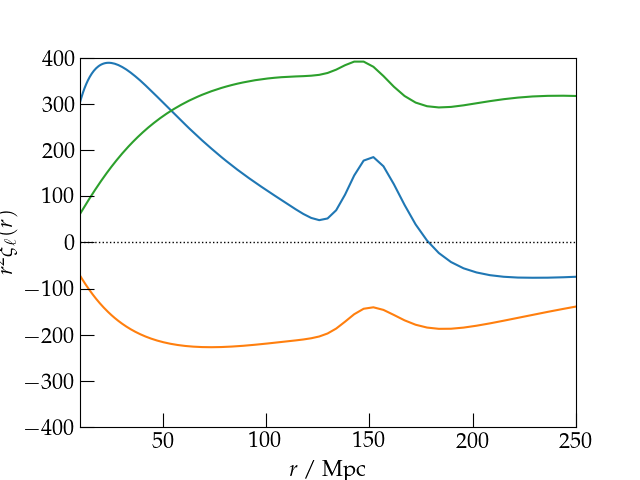

In [7]:
fig, ax = plt.subplots()

ax.plot( r, r**2 *  xi0 )
ax.plot( r, r**2 *  xi2 )
ax.plot( r, r**2 *  xi4 * 30 )

ax.axhline( 0.0, lw=1, ls=':', c='k')
# ax.plot( r*h, (r*h)**2 *  xi4 )

ax.set_xlim(10,250)
ax.set_ylim(-400,400)
# ax.semilogx()

ax.set_xlabel('$r$ / Mpc')
ax.set_ylabel('$r^2 \\xi_\\ell(r)$')


In [8]:
# list of parameters with respect to which we take derivatives

## Cosmological Parameters
Tcmb    = 2.7255
YHe     = 0.248
Omegam  = 0.3099
Omegab  = 0.0488911
# OmegaDE = 1.0-Omegam
w_DE_0  = -0.99
w_DE_a  = 0.00
cs2_DE  = 0.99
num_massive_neutrinos = 1
mnu     = 0.06  #eV
Neff    = 2.046 # -1 if massive neutrino present
standard_neutrino_neff=Neff+num_massive_neutrinos
H0      = 67.742
A_s     = 2.1064e-09
n_s     = 0.96822

fieldnames = ['H_0', '\\Omega_m', '\\Omega_b', 'N_{eff}', 'm_{\\nu}', 'T_{CMB}', 'w_0', '(1+w_a)', 'n_s']#, 'w_0', 'w_a', 'c_s^2']
fiducial_cosmo_param = jnp.array([H0, Omegam, Omegab, Neff, mnu, Tcmb, w_DE_0, w_DE_a, n_s,])#  w_DE_0, w_DE_a, cs2_DE])

def xi_RSD_of_cosmo( args ):
  param = {}
  param['Omegam'] = args[1]
  param['Omegab'] = args[2]
  param['OmegaDE'] = 1-args[1]
  param['Omegak'] = 0.0
  param['A_s'] = A_s
  param['n_s'] = args[8]
  param['H0'] = args[0]
  param['Tcmb'] = args[5]
  param['YHe'] = YHe
  param['Neff'] = args[3]
  param['Nmnu'] = num_massive_neutrinos
  param['mnu'] = args[4]
  param['w_DE_0'] = args[6]
  param['w_DE_a'] = args[7]
  param['cs2_DE'] = 1.0
  param['k_p'] = 0.05

  k_p  = 0.05

  ## compute the background evolution
  param = evolve_background(param=param)  
  y, kmodes = evolve_perturbations( param=param, kmin=kmin, kmax=kmax, num_k=nmodes, 
                aexp_out=jnp.array([1.0]), rtol=1e-4, atol=1e-4 )

  P0, P2, P4 = power_multipoles( y=y[:,-1,:], kmodes=kmodes, b=2.0, param=param )

  xi0, r = get_xi_from_P( k=kmodes, Pk=P0, N=nmodes, ell=0 )
  xi2, r = get_xi_from_P( k=kmodes, Pk=P2, N=nmodes, ell=2 )
  xi4, r = get_xi_from_P( k=kmodes, Pk=P4, N=nmodes, ell=4 )

  return jnp.array([xi0,xi2,xi4])


In [9]:
y = xi_RSD_of_cosmo( fiducial_cosmo_param )

In [10]:

dy = jax.jacfwd(xi_RSD_of_cosmo)(fiducial_cosmo_param)

(1, 1000.0)

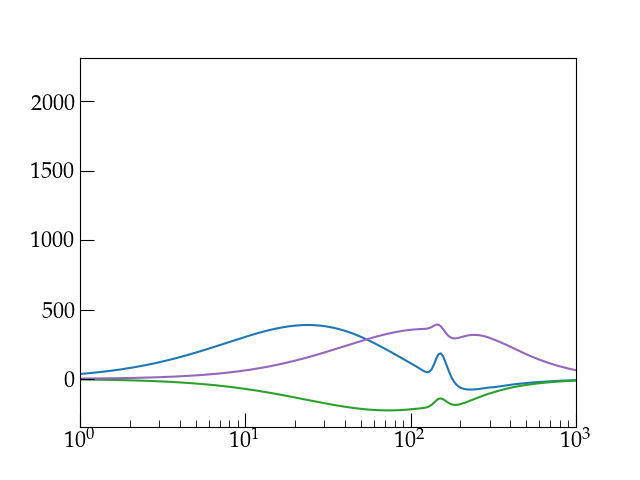

In [11]:
fig, ax = plt.subplots()

ax.semilogx( r, r**2 * jnp.real(xi0), c='C0')
ax.semilogx( r, r**2 * jnp.real(xi2), c='C2' )
ax.semilogx( r, r**2 * jnp.real(xi4) * 30, c='C4' )

ax.set_xlim(1,1e3)

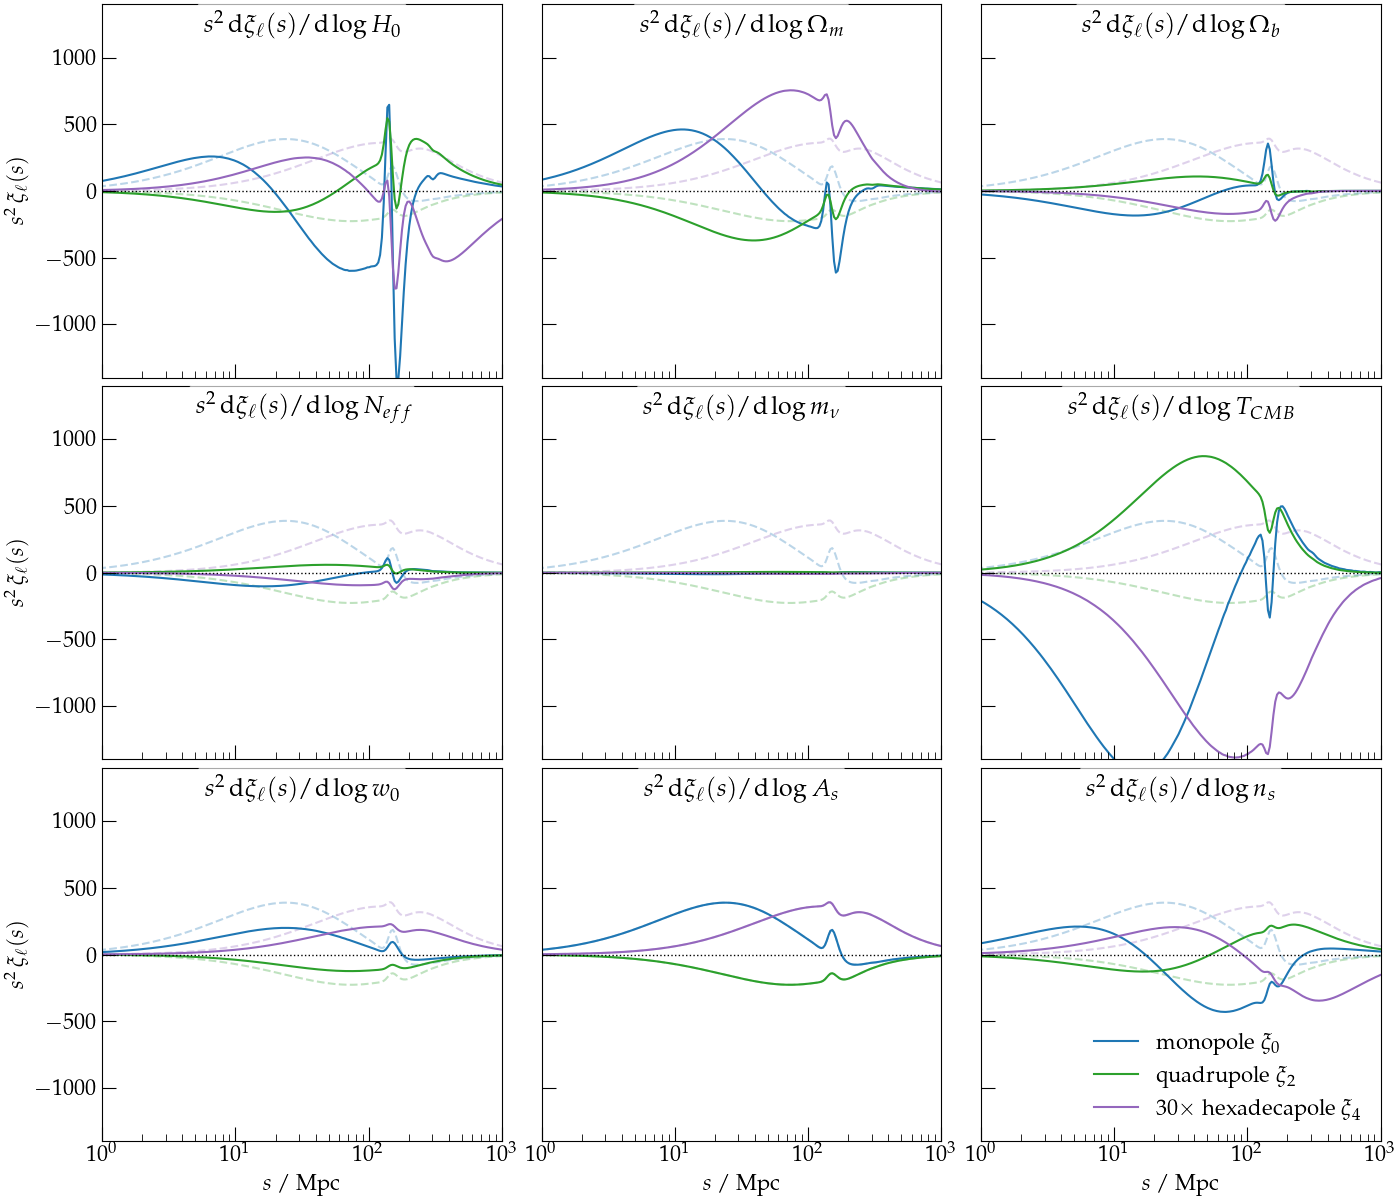

In [12]:
## make the plot
plt.rcParams['axes.titley'] = 1.0    # y is in axes-relative coordinates.
plt.rcParams['axes.titlepad'] = -20  # pad is in points...

fig,ax = plt.subplots(3,3,sharex=True,sharey=True,figsize=(14,12),layout='constrained')#, gridspec_kw={'height_ratios': [2,1,2,1,2,1,2,1]})

title_bbox = dict(boxstyle="round,pad=0.3", edgecolor="none", facecolor="white", alpha=0.667)
lw = 1.5
for i in range(9):
  iy = i%3
  ix = i//3
  ax[ix,iy].plot( r, r**2 * jnp.real(xi0), c='C0', ls='--', alpha=0.3, lw=lw )
  ax[ix,iy].plot( r, r**2 * jnp.real(xi2), c='C2', ls='--', alpha=0.3, lw=lw )
  ax[ix,iy].plot( r, r**2 * jnp.real(xi4) * 30, c='C4', ls='--', alpha=0.3, lw=lw )

  ax[ix,iy].plot( r, r**2 * fiducial_cosmo_param[i] * jnp.real(dy[0,:,i]), label=f'monopole $\\xi_0$', c='C0', lw=lw )
  # ax[ix,iy].plot( r, r**2 * xi0, c='C0', alpha=0.3 )
  ax[ix,iy].plot( r, r**2 * fiducial_cosmo_param[i] * jnp.real(dy[1,:,i]), label=f'quadrupole $\\xi_2$', c='C2', lw=lw )
  # ax[ix,iy].plot( r, r**2 * xi2, c='C2', alpha=0.3 )
  # ax[ix,iy].plot( r, r**2 * dy[2,:,i], label=f'hexadecapole $\\xi_4$', c='C4' )
  # ax[ix,iy].plot( r, r**2 * xi4, c='C4', alpha=0.3 )

  ax[ix,iy].plot( r, r**2 * fiducial_cosmo_param[i] * jnp.real(dy[2,:,i]) * 30, label=f'30$\\times$ hexadecapole $\\xi_4$', c='C4', lw=lw )

  ax[ix,iy].set_title(f'$s^2\\,\\mathrm{{d}}  \\xi_{{\\ell}}(s) / \\mathrm{{d}} \\log {fieldnames[i]}$', bbox=title_bbox, fontsize=18)

for a in ax.flatten():
  a.semilogx()
  a.axhline( 0.0, lw=1, ls=':', c='k')
  a.set_xlim(1,1e3)
  a.set_ylim(-1400,1400)

# ax.legend()
# ax.plot( r, r**2 *  dy[:,0] )

# ax.plot( r, r**2 *  xi2 )
# ax.plot( r, r**2 *  xi4 )

# ax.axhline( 0.0, lw=1, ls=':', c='k')
# ax.plot( r*h, (r*h)**2 *  xi4 )

# ax.set_xlim(1,1e3)
# ax.set_ylim(-300,500)
# ax.semilogx()

for a in ax[-1,:]:
  a.set_xlabel('$s$ / Mpc')
# ax.set_ylabel('$r^2 \\xi_\\ell(r)$')

for a in ax[:,0]:
  a.set_ylabel('$s^2\,\\xi_{{\\ell}}(s)$')

ax[-1,-1].legend(loc='lower right', fontsize=16, frameon=False)

plt.savefig('derivative_correlation_function.pdf',bbox_inches='tight')